Step 0 - Loading Parameters and Libraries

In [50]:
import DrainMethod
import sys
import os

## General parameters 

input_dir = os.path.join(os.getcwd(), "logs") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs

#logName = 'Ciena_error_lin0es_20220701-20220715.txt' # Name of file to be parsed
logName = 'ciena-mini.txt' # Name of file to be parsed
#logName = 'Andriod_2k.log' # Name of file to be parsed
#logName = 'trat3_production_1650_1700_20231411_raw.txt' # Name of file to be parsed

log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution

Step 1 - Log Parsing Using Drain

In [51]:
from pathlib import Path
import pickle

## Drain parameters
st = 0.5 # Drain similarity threshold
depth = 5 # Max depth of the parsing tree

## Parses file, using DrainMethod
print('\n=== Starting Drain Parsing ===')
indir = os.path.join(input_dir, os.path.dirname(logName))
print(indir)
log_file = os.path.basename(logName)

parser = DrainMethod.LogParser(log_format=log_format, indir=indir, outdir=output_dir, rex=regex, depth=depth, st=st)
parser.parse(log_file)

parsedresult=os.path.join(output_dir, log_file + '_structured.csv')


=== Starting Drain Parsing ===
c:\Users\vbert\OneDrive\DOUTORADO Poly Mtl\Projeto\LineTracker\LineTracker\logs\
Parsing file: c:\Users\vbert\OneDrive\DOUTORADO Poly Mtl\Projeto\LineTracker\LineTracker\logs\ciena-mini.txt


Parsing Progress: 100%|██████████| 15710/15710 [00:01<00:00, 11755.27it/s]


Parsing done. [Time taken: 0:00:03.776132]


Step 2 - Creating Embeddings Using TFIDF

In [52]:
## Step 2 - Vector Creation Using TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer
from pathlib import Path
import pandas as pd
import regex as re
import contextlib
import pickle

# Calls conversion from data to dataframe
def load_data():
    headers, regex = generate_logformat_regex(log_format)
    return log_to_dataframe(os.path.join(indir, logName), regex, headers, log_format)

# Preprocesses dataframe with regexes, if necessary - more preprocessing to add
def preprocess_df(df_log):
    for idx, content in df_log["Content"].items():
        for currentRex in regex:
            df_log.at[idx,'Content'] = re.sub(currentRex, '<*>', content)
    return df_log

# Function to generate regular expression to split log messages
def generate_logformat_regex(log_format):
    headers = []
    splitters = re.split(r'(<[^<>]+>)', log_format)
    regex = ''
    for k in range(len(splitters)):
        if k % 2 == 0:
            splitter = re.sub(' +', '\\\s+', splitters[k])
            regex += splitter
        else:
            header = splitters[k].strip('<').strip('>')
            regex += f'(?P<{header}>.*?)'
            headers.append(header)
    regex = re.compile('^' + regex + '$')
    return headers, regex

# Function to transform log file to dataframe 
def log_to_dataframe(log_file, regex, headers, logformat):
    log_messages = []
    linecount = 0
    with open(log_file, 'r') as fin:
        for line in fin.readlines():
            with contextlib.suppress(Exception):
                match = regex.search(line.strip())
                message = [match.group(header) for header in headers]
                log_messages.append(message)
                linecount += 1
    logdf = pd.DataFrame(log_messages, columns=headers)
    logdf.insert(0, 'LineId', None)
    logdf['LineId'] = [i + 1 for i in range(linecount)]
    return logdf

# Transforms the dataset, creating raw vector file
def transform_dataset(raw_content):
    
    path_to_file = os.path.join(vector_dir, logName + '_vectors_TFIDF.vec')
    path = Path(path_to_file)
    vectors_tfidf = []

    # Saves transformed file, for further executions
    if (path.is_file()):
        print("Using Previous Embeddings File")
        vectors_tfidf = pickle.load(open(path_to_file, 'rb'))
    else:
        # Using TFIDF Vectorizer 
        print("Starting Encoding")
        tr_idf_model  = TfidfVectorizer()
        vectors_tfidf = tr_idf_model.fit_transform(raw_content)
        pickle.dump(vectors_tfidf, open(path_to_file, 'wb'))
    
    return vectors_tfidf

# Creates embeddings for log file
def transform(logName):
    print('Transforming file: ' + os.path.join(input_dir, logName))
    log_df = load_data()
    log_df = preprocess_df(log_df)
    return transform_dataset(log_df["Content"])

vector_df = transform(os.path.basename(logName))
print("The dimensions of the embedding matrix are ({}, {})".format(vector_df.shape[0], vector_df.shape[1]))

Transforming file: c:\Users\vbert\OneDrive\DOUTORADO Poly Mtl\Projeto\LineTracker\LineTracker\logs\ciena-mini.txt
Using Previous Embeddings File
The dimensions of the embedding matrix are (15710, 8224)


Step 3 - Creating Distance Matrix, Using Cosine Distance

In [53]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

tfidf_distance = cosine_distances(vector_df)
print("The dimensions of the distance matrix are {}".format(tfidf_distance.shape))

The dimensions of the distance matrix are (15710, 15710)


Step 3 - Creating Matrix of Parsed Items (Variable Matrix)

In [60]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval
import pandas as pd 

## General Parameters
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
output_csv = os.path.join(output_dir, log_file + '_structured.csv') # The file with parsed results

# Reads parameters list
full_df = pd.read_csv(output_csv)

# Breaks the string into lists
full_df["ParameterList"] = full_df["ParameterList"].apply(literal_eval)

# Transforms variable list to variable sparse matrix
mlb = MultiLabelBinarizer(sparse_output=True)
var_df = mlb.fit_transform(full_df["ParameterList"])

# Code for Jaccard Distance
def jaccard_distance(mat):
    rows_sum = mat.getnnz(axis=1)
    ab = mat * mat.T

    # For rows
    aa = np.repeat(rows_sum, ab.getnnz(axis=1))
    # For columns
    bb = rows_sum[ab.indices]

    # Calculates Jaccard similarity
    similarities = ab.copy()
    similarities.data = similarities.data/(aa + bb - ab.data)

    # Calculated Jaccard distance
    distance = 1 - similarities.todense()

    return distance

var_distance = jaccard_distance(var_df)

# Normalizes Variable Matrix with Min-Max
min_val = np.min(var_distance)
max_val = np.max(var_distance)
var_distance = (var_distance - min_val) / (max_val - min_val)

print("The dimensions of the variable matrix are {}".format(var_distance.shape))

The dimensions of the variable matrix are (15710, 15710)


Step 4 - Creates Closeness Matrix

In [59]:
# Creates Count Matrix using line numbers from log lines as the counter
count_list = []
n = len(tfidf_distance)
count_distance = np.abs(np.arange(n)[:, np.newaxis] - np.arange(n))

# Normalizes Distance Matrix with Min-Max
min_val = np.min(count_distance)
max_val = np.max(count_distance)
count_distance = (count_distance - min_val) / (max_val - min_val)
print("The dimensions of the closeness matrix are {}".format(count_distance.shape))

[[    0     1     2 ... 15707 15708 15709]
 [    1     0     1 ... 15706 15707 15708]
 [    2     1     0 ... 15705 15706 15707]
 ...
 [15707 15706 15705 ...     0     1     2]
 [15708 15707 15706 ...     1     0     1]
 [15709 15708 15707 ...     2     1     0]]
The dimensions of the count matrix are (15710, 15710)


Step 5 (Optional) - Saves/Loads Matrices

In [61]:
# Saving matrices

# print("Saving distance matrix")
# np.save("tfidf_distance.csv", tfidf_distance)
# print("Saving variables matrix")
# np.save("var_distance.csv", var_distance)
# print("Saving count matrix")
# np.save("count_distance.csv", count_distance)

# Loading matrices

print("Loading distance matrix")
tfidf_distance = np.load("tfidf_distance.csv")
print("Loading count matrix")
count_distance = np.load("count_distance.csv")
print("Loading variables matrix")
var_distance = np.load("var_distance.csv")

Saving distance matrix
Saving variables matrix
Saving count matrix


Step 6 - Applies Weights to the Matrices

In [62]:
# Using alpha to define the weight of the TFIDF Matrix,  Beta to define the weight of the Variable Matrix,
# and Gamma to define the weight of the Count Matrix
alpha = 0.5
beta = 0.3
gamma = 0.2

if alpha+beta+gamma != 1:
   raise Exception("Values have to sum 1!")

# New matrices, corrected by the weights
tfidf_distance_wtd = np.dot(alpha,tfidf_distance)
var_distance_wtd = np.dot(beta, var_distance)
count_distance_wtd = np.dot(gamma, count_distance)

# Sums remaining matrices
distance_matrix = np.asarray(tfidf_distance_wtd + var_distance_wtd + count_distance_wtd)

Step 7 (TO BE ELIMINATED BY ROBIN'S CODE) - Clusters using K-Medoids

In [76]:
## ROBIN'S CODE TO BE PLACED HERE

from sklearn_extra.cluster import KMedoids

clusterer = KMedoids(n_clusters=20, metric='precomputed', random_state=0)
clusterer.fit(distance_matrix)
cluster_num = clusterer.labels_.max()
print ("The number of clusters is {}".format(cluster_num))
cluster_labels = clusterer.labels_
print ("The clusters of each element are {}".format(cluster_labels))


The number of clusters is 19
The clusters of each element are [14 14 11 ... 11 11 12]


Step 8 (TO BE ELIMINATED BY ROBIN'S CODE) - Plots using TSNE

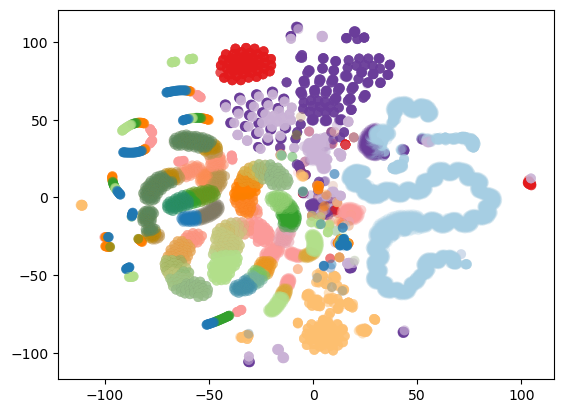

In [73]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

projection = TSNE(metric='precomputed', init='random').fit_transform(distance_matrix)

color_palette = sns.color_palette('Paired', clusterer.labels_.max()+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

Step 9 - Creates Lists of Lines

In [77]:
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim.corpora as corpora
import pandas as pd
import numpy as np
import gensim
import os

## General Parameters
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

# Reads parameters list
full_df = pd.read_csv(output_csv)
elem_df = full_df["Content"]

# Create blank lists
num_clusters = clusterer.labels_.max() + 1
cluster_idxs = [[] for _ in range(num_clusters)]
cluster_lines = [[] for _ in range(num_clusters)]

# Populate the lists with cluster elements
for idx, elem in enumerate(clusterer.labels_):
    if elem != -1:
        cluster_idxs[elem].append(idx)
        cluster_lines[elem].append(elem_df.iloc[idx])

Step 10 - Runs Topic Modeling on each cluster

In [78]:
## Runs BerTopic on each cluster

from sklearn_extra.cluster import KMedoids
from bertopic import BERTopic

topic_model = BERTopic(hdbscan_model = KMedoids(n_clusters = 1), top_n_words=10)
cluster_topics = []

# Function to remove stopwords from each sentence
def remove_stopwords(texts):
    # Parameters
    stop_words = stopwords.words('english')
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

for cluster in range(clusterer.labels_.max()):
    topics, probs = topic_model.fit_transform(cluster_lines[cluster])
    topic_model.get_topic(0)
    top_topic = topic_model.get_topic(0)
    words = [i[0] for i in top_topic]
    cluster_topics.append(words)

2024-01-25 23:29:20,679 - BERTopic - Transformed documents to Embeddings
2024-01-25 23:29:26,499 - BERTopic - Reduced dimensionality
2024-01-25 23:29:26,538 - BERTopic - Clustered reduced embeddings
2024-01-25 23:29:33,129 - BERTopic - Transformed documents to Embeddings
2024-01-25 23:29:35,749 - BERTopic - Reduced dimensionality
2024-01-25 23:29:35,758 - BERTopic - Clustered reduced embeddings
2024-01-25 23:29:39,360 - BERTopic - Transformed documents to Embeddings
2024-01-25 23:29:41,612 - BERTopic - Reduced dimensionality
2024-01-25 23:29:41,614 - BERTopic - Clustered reduced embeddings
2024-01-25 23:29:51,208 - BERTopic - Transformed documents to Embeddings
2024-01-25 23:29:58,060 - BERTopic - Reduced dimensionality
2024-01-25 23:29:58,077 - BERTopic - Clustered reduced embeddings
2024-01-25 23:30:08,772 - BERTopic - Transformed documents to Embeddings
2024-01-25 23:30:11,001 - BERTopic - Reduced dimensionality
2024-01-25 23:30:11,010 - BERTopic - Clustered reduced embeddings
2024-

Step 10 - Finds most similar line inside the cluster to the words of the topic

In [79]:
from nltk.tokenize import WhitespaceTokenizer

tk = WhitespaceTokenizer()

def find_similar_lines(cluster_list, cluster_number, word_list):
    closest_line = 0
    max_similarity = 0

    for idx, line in enumerate(cluster_list[cluster_number]):
        tokenized_line = set(tk.tokenize(line.lower()))
        common_tokens = len(tokenized_line.intersection(word_list))

        if common_tokens > max_similarity:
            max_similarity = common_tokens
            closest_line = idx

    if max_similarity != 0:
        print("In cluster {}, the closest line is {}, with {} identical tokens to the topic".format(cluster_number, closest_line, max_similarity))
        print("The topic is composed of the following words: {}".format(word_list))
        print("Line {} is: {}".format(closest_line, cluster_list[cluster_number][closest_line]))
    else:
        print("No good lines found for cluster {}".format(cluster_number))
    print("\n")

    return closest_line, max_similarity

for cluster in range(len(cluster_topics)):
    find_similar_lines(cluster_lines, cluster, set(cluster_topics[cluster]))


In cluster 0, the closest line is 0, with 8 identical tokens to the topic
The topic is composed of the following words: {'artifact', 'attribute', 'archive', 'type', 'instance', 'unable', 'no', 'to', 'unzipuntar', 'has'}
Line 0 is: Unable to unzip/untar archive /localdisk/6500_repo/ome/vobs/equinox_ne_build/basebuild/EQBASE/ppc/TCSBASE69_T102X/BST012X1510WD153251-cop.bin: Artifact instance has no attribute 'type'


In cluster 1, the closest line is 0, with 7 identical tokens to the topic
The topic is composed of the following words: {'cat', 'usrbinobjdump', 'file', 'or', 'stat', 'no', 'cp', 'such', 'cannot', 'directory'}
Line 0 is: cp: cannot stat '/localdisk/6500_repo/onid/*sim': No such file or directory


In cluster 2, the closest line is 3, with 3 identical tokens to the topic
The topic is composed of the following words: {'command', 'blame', 'null', 'failed', 'error', '128', 'usrbingit', 'proceeding', 'not', 'code'}
Line 3 is: COMMAND: '/usr/bin/git blame -p 6500P_0.c' failed. Erro